In [1]:
import os
import re
import sys
import toml
from dotenv import load_dotenv
import gokart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import toml
from pipelines import  BilevelOptimizationPipeline
from luigi.configuration.toml_parser import LuigiTomlParser
import matplotlib as mpl

# Enable LaTeX rendering for text, allowing usage of \texttt in legend labels
# mpl.rcParams["text.usetex"] = True
# mpl.rcParams["font.family"] = "serif"

os.environ['LUIGI_CONFIG_PARSER'] = 'toml'


In [2]:
from conf.app_adult import get_config

settings = [
    "neumann",
    "unroll",
    "vr_no_km",
    "grazzi_const",
    "vr_km_const",
    "grazzi_linear",
    "vr_km_linear",
]


In [17]:
results = {}
params = {}
config = get_config()
key = "adult"

os.makedirs('.tmp', exist_ok=True)
with open(f'.tmp/params_ipynb_adult_20250622.toml', 'w') as f:
    toml.dump(config, f)

gokart.add_config(f'.tmp/params_ipynb_adult_20250622.toml')
# task_pipeline = gokart.build(HypergradEstimationPipeline(), return_value=True)
task_pipeline = BilevelOptimizationPipeline()
_, results_tmp = task_pipeline.output().load()
labels = list(results_tmp.keys())
label_to_setting = {}
for label in labels:
    for s in settings:
        if s in label:
            label_to_setting[label] = s
            break
results = {label_to_setting[k]: v for k, v in results_tmp.items()}



val_losses (np.float64(0.41588372383357775), np.float64(0.551007455578799))


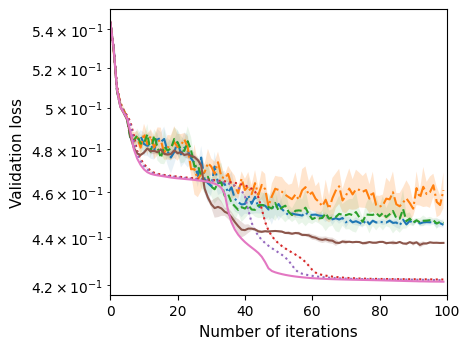

test_losses (np.float64(0.41588372383357775), np.float64(0.551007455578799))


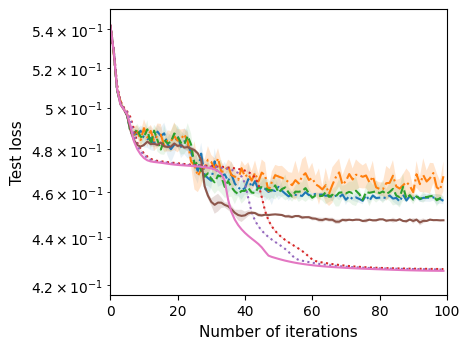

val_metrics (np.float64(0.7489363151426045), np.float64(0.8074397332486685))


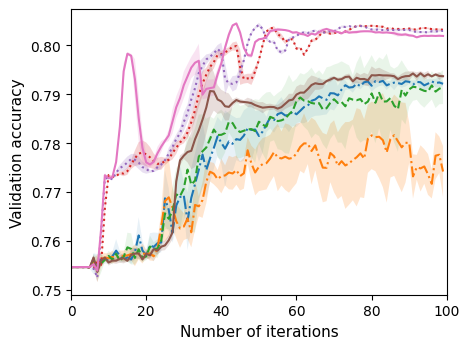

test_metrics (np.float64(0.7489363151426045), np.float64(0.8074397332486685))


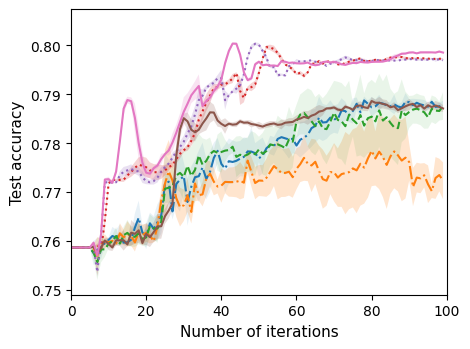

In [ ]:
xlabel = 'Number of iterations'
ylabel = r'$\ell_2$ error from $\nabla_\lambda f$'
xscale = 'linear'
output_dir = './results/'

setting_to_legend = {
    "neumann": "StocFP",
    "unroll": "StocRB",
    "vr_no_km": "MixedFP",
    "grazzi_const": "StocFP+KM→ (StocFP + KM-iteration with constant η)",
    "grazzi_linear": "StocFP+KM↓ (StocFP + KM-iteration with decreasing η)",
    "vr_km_const": "MixedFP+KM→ (MixedFP-KM with constant η)",
    "vr_km_linear": "MixedFP+KM↓ (MixedFP-KM with decreasing η)",
}

setting_to_linestyle = {
    "neumann": "-.",
    "unroll": "-.",
    "vr_no_km": "--",
    "grazzi_const": ":",
    "grazzi_linear": ":",
    "vr_km_const": "-",
    "vr_km_linear": "-",
}

no_fill = [
   'neumann',
   'vr_no_km',
]

metric_to_ylabel = {
    'train_losses': 'Train loss',
    'val_losses': 'Validation loss',
    'test_losses': 'Test loss',
    'train_metrics': 'Train accuracy',
    'val_metrics': 'Validation accuracy',
    'test_metrics': 'Test accuracy',
}
metrics = [
    # 'train_losses', 
    'val_losses', 
    'test_losses',
    # 'train_metrics', 
    'val_metrics',  
    'test_metrics'
]

metric_to_ylims = {
    # 'train_losses': (0.0, 0.0),
    'val_losses': (0.41588372383357775, 0.551007455578799),
    'test_losses': (0.41588372383357775, 0.551007455578799),
    # 'train_metrics': (0.0, 0.0),
    'val_metrics': (0.7489363151426045, 0.8074397332486685),
    'test_metrics': (0.7489363151426045, 0.8074397332486685),
}

metric_to_yscale = {
    'val_losses': 'log',
    'test_losses': 'log',
    'val_metrics': 'linear',
    'test_metrics': 'linear',
}

scale = 1.2
fontsize = 11

for metric in metrics:
    fig, ax = plt.subplots(figsize=(4*scale, 3*scale))
    # Ensure grid is not shown
    ax.grid(False)
    for method, label in setting_to_legend.items():
        res = results[method]
        # param_ = param[method]  # Uncomment if you need to use parameters for further customization.
        means = res[f'{metric}_mean']
        xs = np.arange(len(means))
        ys = means[xs]

        ax.plot(xs, ys, label=label, linestyle=setting_to_linestyle[method])

        if method in no_fill:
            alpha = 0.1
        else:
            alpha = 0.2
        stds = res[f'{metric}_std'][xs]
        ax.fill_between(xs, ys - stds, ys + stds, alpha=alpha)
    # title
    # ax.set_title("Hyperparam. Optimization", fontsize=fontsize)
    ax.set_xscale(xscale)
    ax.set_yscale(metric_to_yscale[metric])
    ax.set_ylabel(metric_to_ylabel[metric], fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylim(metric_to_ylims[metric])
    ax.set_xlim(0, max(xs)+1)
    # ax.legend()
    # print(metric, ax.get_ylim())

    fig.tight_layout()
    os.makedirs(output_dir, exist_ok=True)
    pdf_path = os.path.join(output_dir, f'bo_adult_{metric}.pdf')
    fig.savefig(pdf_path)
    # print ylims
    plt.show()

In [26]:
def get_legend(labels, markers=None, colors=None, styles=None, markersizes=None, ncol=1):
    if markersizes is None:
        markersizes = [None] * len(labels)
    if styles is None:
        styles = [None] * len(labels)
    if colors is None:
        colors = [None] * len(labels)
    if markers is None:
        markers = [None] * len(labels)

    assert len(labels) == len(markers) == len(colors)

    fig, ax = plt.subplots()
    for label, marker, color, style, markersize in zip(labels, markers, colors, styles, markersizes):
        ax.plot(np.ones(1), np.ones(1), label=label, marker=marker, color=color, linestyle=style, markersize=markersize)
    legends = []
    for line, line_name in zip(*fig.axes[0].get_legend_handles_labels()):
        legends.append(line)
    fig2 = plt.figure()
    ax2 = fig2.add_subplot()
    ax2.axis('off')
    legend = ax2.legend(legends, labels, frameon=False, loc='lower center', ncol=ncol)
    fig_legend = legend.figure
    fig_legend.canvas.draw()

    return legend

def get_tight_legend_bbox_inches(legend):
    bbox = legend.get_window_extent().transformed(legend.figure.dpi_scale_trans.inverted())
    return bbox

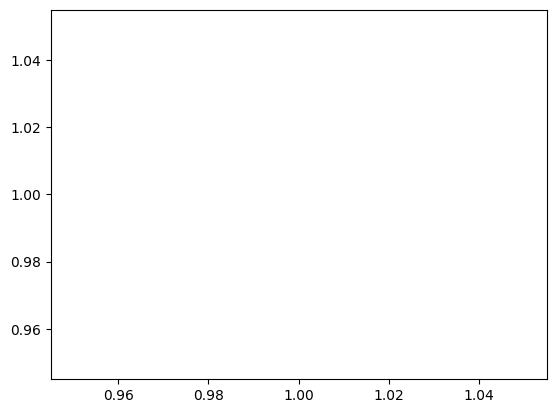

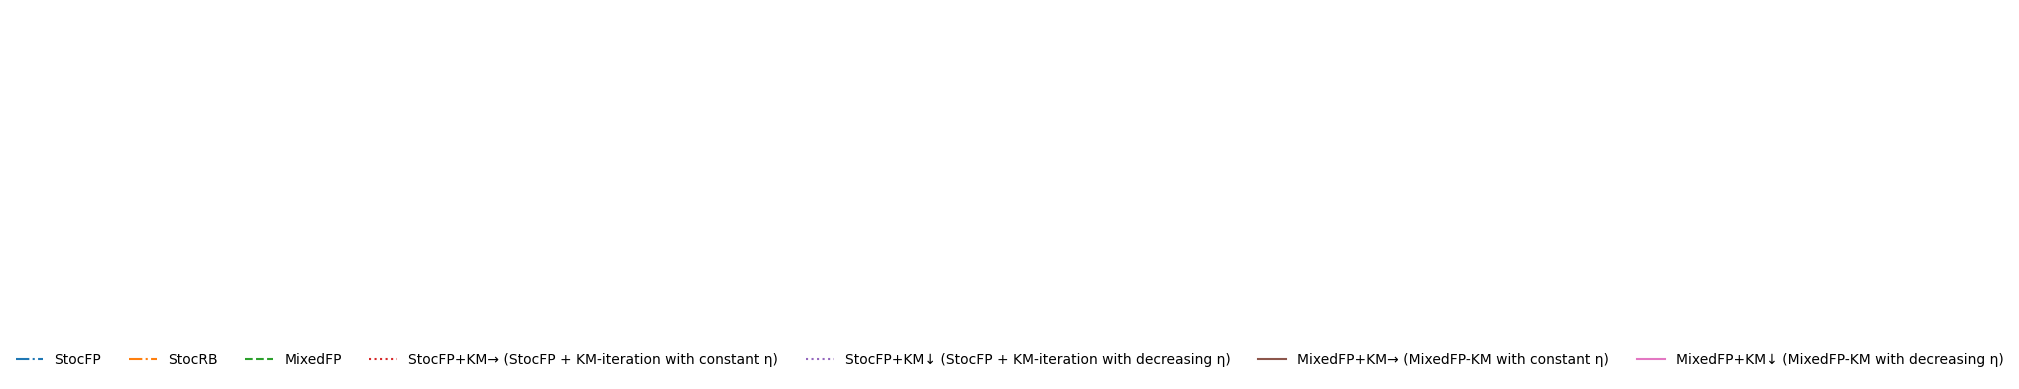

In [40]:
legend = get_legend(labels=setting_to_legend.values(), styles=setting_to_linestyle.values(), ncol=len(settings))

bbox = get_tight_legend_bbox_inches(legend)
bbox = bbox.from_extents(bbox.xmin, bbox.ymin, bbox.xmax, bbox.ymax * 1.02)  # Increase the height by 20%

legend.figure.savefig(os.path.join(output_dir, f"legends_bo.pdf"), dpi="figure", bbox_inches=bbox)
# legend.figure.savefig(os.path.join(out_dir, "legends_cleansing.pdf"), dpi="figure")
